# setup

In [ ]:
import os, re, json, glob, math, sys, random
from pathlib import Path
from typing import Dict, Iterable, Optional, Sequence, Tuple, Set
from collections import defaultdict, Counter, deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, ScalarFormatter

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Subset

# ----------------------------
# Project root (repo)
# ----------------------------
PROJ_ROOT = Path("/home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation")
SRC_DIR = PROJ_ROOT / "src"

if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

# ----------------------------
# Local package imports (src/otu_taxa)
# ----------------------------
from otu_taxa.dataloaders_unk_balanced import (
    OTUTaxaDataset,
    MaskingConfig,
    make_tax_only_mask_collator,
)

from otu_taxa.helpers_taxa_prediction import (
    load_vocab_json,
    norm_id,
    parse_tax_to_cols,
    is_unknown,
    evaluate_and_plot_predictions,
)

# UNK-aware metrics / decoding helpers
from otu_taxa.joint_hier_loss_metrics_unk import (
    hierarchical_predict_full_path,
    make_factorized_tax_loss_fn_fast_masked_with_unk,
    get_tax_path_for_label,
    deepest_taxonomy_accuracy_f1,   # often useful in testing
)

# UNK-aware model
from otu_taxa.otu_taxa_transformer_unk import (
    ModelConfig,
    OTUTaxaTransformerEmbedTaxTreeUnkTaxa,
)
from otu_taxa.helpers_pretraining_model import IGNORE_INDEX, set_seed



# load model

In [2]:
# ---------------------------
# Run paths (inside repo)
# ---------------------------
run_name = "pretrain_hier_joint_unk_taxa"
RUN_DIR   = os.path.join(PROJ_ROOT, "runs_microbeatlas", run_name)
META_PATH = os.path.join(RUN_DIR, "meta.json")
CKPT_PATH = os.path.join(RUN_DIR, "best.pt")

with open(META_PATH, "r") as f:
    meta = json.load(f)

# ---------------------------
# External (heavy) dataset location (outside repo)
# Use EXACT same path construction as training
# ---------------------------
DATASET_ROOT = "/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training"
dataset_folder_name = meta.get("dataset_folder_name", "dataset_full_top999")  # prefer meta if saved

dataset_dir = os.path.join(
    DATASET_ROOT,
    "level_97",
    "silva-138.2",
    "incomplete_silva_sintax",
    dataset_folder_name,
)

SAMPLES_JSONL = os.path.join(dataset_dir, "samples.jsonl")
TREE_DIR = os.path.join(dataset_dir, "tree_artifacts")

assert os.path.isfile(SAMPLES_JSONL), f"Missing samples.jsonl: {SAMPLES_JSONL}"
assert os.path.isdir(TREE_DIR), f"Missing tree_artifacts dir: {TREE_DIR}"

print("[INFO] dataset_dir:", dataset_dir)

[INFO] dataset_dir: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999


In [3]:
# ---------------------------
# Rebuild EXACT split used in tail-OTU heldout training (from saved JSON)
# Train = samples with NONE of the selected OTUs  (precomputed indices)
# Test  = held-out samples with >=1 selected OTU (precomputed indices)
# Val   = random subset of Train (clean validation)
# ALSO: load selected_otus for masking/eval later
# ---------------------------

seed = meta.get("seed", 123)
set_seed(seed)
random.seed(seed)

ds = OTUTaxaDataset(dataset_dir)
N = len(ds)
print(f"[INFO] Dataset size: N={N}")

# ---- split file (your real path) ----
SPLIT_JSON = "/home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/notebooks/test_k_shot/split_tail80_nOTU200_seed123.json"

with open(SPLIT_JSON, "r") as f:
    split = json.load(f)

# indices used during training
train_idx   = sorted(split["train_indices"])
heldout_idx = sorted(split["heldout_indices"])   # becomes TEST set now

# OTU pool used to define the split (now we care about this too)
selected_otus = split["selected_otus"]
selected_otus_set = set(selected_otus)

# ---- safety checks----
assert len(train_idx) + len(heldout_idx) == N, "Split indices do not sum to N"
assert set(train_idx).isdisjoint(set(heldout_idx)), "Train/Heldout overlap detected"

print(f"[SPLIT:TAIL] Train(clean)={len(train_idx)}  Heldout={len(heldout_idx)}  (Total N={N})")
print(f"[SPLIT:TAIL] Heldout fraction = {len(heldout_idx)/N:.4f}")

# ---- build VAL from train_idx  ----
VAL_N = meta.get("VAL_N", 20_000)    # keep meta logic
VAL_N = min(VAL_N, len(train_idx))

train_idx_shuf = train_idx.copy()
random.shuffle(train_idx_shuf)

val_idx         = sorted(train_idx_shuf[:VAL_N])
train_idx_final = sorted(train_idx_shuf[VAL_N:])

test_idx = heldout_idx

print(f"[SPLIT:FINAL] Train={len(train_idx_final)}  Val={len(val_idx)}  Test(heldout)={len(test_idx)}")

train_ds = Subset(ds, train_idx_final)
val_ds   = Subset(ds, val_idx)
test_ds  = Subset(ds, test_idx)

# ---- optional reporting ) ----
print("\n[OTU POOL INFO]")
print(f"  tail_quantile: {split['tail_quantile']}")
print(f"  threshold_samples: {split['threshold_samples']}")
print(f"  n_sampled_otus: {split['n_sampled_otus']}")
print(f"  seed: {split['seed']}")
print(f"  selected_otus: {len(selected_otus)} (preview: {selected_otus[:15]})")


[INFO] Dataset size: N=1836250
[SPLIT:TAIL] Train(clean)=1651900  Heldout=184350  (Total N=1836250)
[SPLIT:TAIL] Heldout fraction = 0.1004
[SPLIT:FINAL] Train=1631900  Val=20000  Test(heldout)=184350

[OTU POOL INFO]
  tail_quantile: 0.8
  threshold_samples: 4445
  n_sampled_otus: 200
  seed: 123
  selected_otus: 200 (preview: [33840, 42904, 14141, 28358, 46076, 20141, 50168, 26981, 61167, 45753, 35330, 27457, 31448, 34015, 37095])


In [4]:
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"

# ---------------------------
# Experiment & run names (NEW layout)
# ---------------------------
run_name = "pretrain_tail_80_otus_200"
experiment_name = "runs_microbeatlas_k_shot"

RUN_DIR   = os.path.join(PROJ_ROOT, experiment_name, run_name)
CKPT_PATH = os.path.join(RUN_DIR, "best.pt")
META_PATH = os.path.join(RUN_DIR, "meta.json")

# ---------------------------
# 1) meta.json strict load  (MOVE UP so dataset_dir matches training)
# ---------------------------
with open(META_PATH, "r") as f:
    meta = json.load(f)

mc = meta.get("model_cfg")
if mc is None:
    raise KeyError("meta.json must contain 'model_cfg'.")

required_mc = ["d_model", "n_layers", "n_heads", "d_ff", "dropout", "activation"]
missing = [k for k in required_mc if k not in mc]
if missing:
    raise KeyError(f"meta['model_cfg'] missing required keys: {missing}")

# ---------------------------
# Full MicrobeAtlas dataset path (EXACT training logic)
# ---------------------------
DATASET_ROOT = "/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training"
dataset_folder_name = meta.get("dataset_folder_name", "dataset_full_top999")  # <-- CHANGED

dataset_dir = os.path.join(
    DATASET_ROOT,
    "level_97",
    "silva-138.2",
    "incomplete_silva_sintax",
    dataset_folder_name,
)

TREE_DIR = os.path.join(dataset_dir, "tree_artifacts")
UNK_VOCAB_PATH = os.path.join(TREE_DIR, "taxonomy_vocab_with_unk.json")
UNK_M_PATH     = os.path.join(TREE_DIR, "descendant_matrix_with_unk.npy")
RANK_IDX_PATH  = os.path.join(TREE_DIR, "rank_idx.npy")

# ---------------------------
# Output location for predictions
# ---------------------------
OUT_DIR = Path(dataset_dir) / "predictions_of_taxa" / experiment_name / run_name
OUT_DIR.mkdir(parents=True, exist_ok=True)

# if Cell 2 loaded `split`, use it to name output (you said now you care about selected OTUs)
OUT_JSONL = OUT_DIR / f"pred_tail{int(100*split['tail_quantile'])}_nOTU{split['n_sampled_otus']}_seed{split['seed']}_affected_taxonomy.jsonl"

# ---------------------------
# 2) dataset sizes + strict consistency checks
# ---------------------------
ds = OTUTaxaDataset(dataset_dir)
O_ds = ds.O
T_real_ds = ds.T

ds_meta = meta.get("dataset", {})
if not ds_meta:
    raise KeyError("meta.json must contain 'dataset' with O/T info.")

mO     = ds_meta.get("O")
T_real = ds_meta.get("T_real")
T_base = ds_meta.get("T_base")

if mO is None or T_real is None or T_base is None:
    raise KeyError("meta['dataset'] must contain 'O', 'T_real', 'T_base'.")

if mO != O_ds:
    raise ValueError(f"Dataset O mismatch: meta O={mO}, dataset O={O_ds}")

if T_real != T_real_ds:
    raise ValueError(f"Dataset T_real mismatch: meta T_real={T_real}, dataset T={T_real_ds}")

pad_otu_id  = O_ds
mask_otu_id = O_ds + 1

pad_tax_id  = T_base
mask_tax_id = T_base + 1

n_otus = O_ds + 2
n_taxa = T_base + 2

# ---------------------------
# 3) Load UNK tree artifacts required for hierarchical loss/decoding
# ---------------------------
with open(UNK_VOCAB_PATH, "r") as f:
    tax_vocab_unk = json.load(f)
if len(tax_vocab_unk) != T_base:
    raise ValueError(f"UNK vocab length mismatch: len(vocab_unk)={len(tax_vocab_unk)} vs T_base={T_base}")

M_np = np.load(UNK_M_PATH)
if M_np.shape != (T_base, T_base):
    raise ValueError(f"Descendant matrix shape mismatch: {M_np.shape} vs expected {(T_base, T_base)}")

rank_idx = np.load(RANK_IDX_PATH)
if rank_idx.shape[0] != T_base:
    raise ValueError(f"rank_idx length mismatch: {rank_idx.shape} vs T_base={T_base}")

M_tensor = torch.from_numpy(M_np).to(DEVICE)
rank_idx_t = torch.from_numpy(rank_idx).to(DEVICE)

# ---------------------------
# 4) Build loss fn (keeps model construction identical to training)
# ---------------------------
hier_tax_loss_fn = make_factorized_tax_loss_fn_fast_masked_with_unk(
    M_tensor=M_tensor,
    rank_idx=rank_idx_t,
    tax_vocab=tax_vocab_unk,
    T_base=T_base,
)

# ---------------------------
# 5) Instantiate model exactly and strict checkpoint load
# ---------------------------
cfg = ModelConfig(**mc)

model = OTUTaxaTransformerEmbedTaxTreeUnkTaxa(
    n_otus=n_otus,
    n_taxa=n_taxa,
    pad_otu_id=pad_otu_id,
    pad_tax_id=pad_tax_id,
    config=cfg,
    tax_loss_fn=hier_tax_loss_fn,
)

raw = torch.load(CKPT_PATH, map_location="cpu")
if not isinstance(raw, dict):
    raise TypeError("Checkpoint must be a dict-like object.")

if "model" in raw and isinstance(raw["model"], dict):
    sd = raw["model"]
elif "state_dict" in raw and isinstance(raw["state_dict"], dict):
    sd = raw["state_dict"]
else:
    raise KeyError("Checkpoint must contain either 'model' or 'state_dict'.")

def strip_prefix_if_all(state_dict, prefix: str):
    keys = list(state_dict.keys())
    if keys and all(k.startswith(prefix) for k in keys):
        return {k[len(prefix):]: v for k, v in state_dict.items()}
    return state_dict

sd = strip_prefix_if_all(sd, "model.")
sd = strip_prefix_if_all(sd, "module.")

model.load_state_dict(sd, strict=True)
model.to(DEVICE).eval()

print("[OK] strict load succeeded; model on", DEVICE)
print(f"[INFO] dataset_dir={dataset_dir}")
print(f"[INFO] O={O_ds}, T_real={T_real}, T_base={T_base}, n_taxa={n_taxa}")
print(f"[INFO] OUT_JSONL={OUT_JSONL}")


UNK ids per rank: [6928, 6929, 6930, 6931, 6932, 6933, 6934]


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[OK] strict load succeeded; model on cuda:1
[INFO] dataset_dir=/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999
[INFO] O=62200, T_real=6929, T_base=6935, n_taxa=6937
[INFO] OUT_JSONL=/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999/predictions_of_taxa/runs_microbeatlas_k_shot/pretrain_tail_80_otus_200/pred_tail80_nOTU200_seed123_affected_taxonomy.jsonl


# split test in Support and Query

In [5]:
from collections import defaultdict
import random
import torch

def build_kshot_support_query_split_simple(
    subset_ds,
    heldout_otus,
    *,
    O_ds: int,
    K_max: int = 20,
    seed: int = 123,
    otu_key: str = "otus",
    allow_replacement: bool = True,
    query_max: int = 1000,   # NEW: cap query size (None = keep all)
    query_frac: float = None, # NEW: alternatively cap by fraction (e.g., 0.01)
    verbose: bool = True,
):
    """
    Same main logic as before.
    NEW: query set can be subsampled to a fixed size (query_max) or fixed fraction (query_frac).
    """

    if K_max < 1:
        raise ValueError(f"K_max must be >= 1, got {K_max}")

    if query_frac is not None and not (0.0 < query_frac <= 1.0):
        raise ValueError(f"query_frac must be in (0,1], got {query_frac}")

    rng = random.Random(seed)
    heldout_otus = sorted(set(map(int, heldout_otus)))
    heldout_set = set(heldout_otus)

    def extract_otus(rec):
        if isinstance(rec, dict):
            x = rec.get(otu_key, [])
        else:
            x = rec[0]
        if torch.is_tensor(x):
            x = x.detach().cpu().view(-1).tolist()
        return [int(v) for v in x]

    # 1) Build candidates per OTU
    otu_to_candidates = {o: [] for o in heldout_otus}

    for i in range(len(subset_ds)):
        otus = extract_otus(subset_ds[i])
        otus = [o for o in otus if 0 <= o < O_ds]     # exclude PAD/MASK
        present = set(otus) & heldout_set
        for o in present:
            otu_to_candidates[o].append(i)

    # 2) Sample support_max per OTU
    support_max = {}
    usable_otus = []
    replacement_used = {}

    for o in heldout_otus:
        cand = otu_to_candidates.get(o, [])
        n = len(cand)

        if n == 0:
            continue

        if n >= K_max:
            chosen = rng.sample(cand, K_max)          # no replacement
            replacement_used[o] = False
        else:
            if not allow_replacement:
                continue
            chosen = [rng.choice(cand) for _ in range(K_max)]  # with replacement
            replacement_used[o] = True

        support_max[o] = chosen
        usable_otus.append(o)

    usable_otus = sorted(usable_otus)

    # 3) Full fixed query = complement of ANY index used in max support (unique complement)
    used_support_any = set()
    for o in usable_otus:
        used_support_any.update(support_max[o])

    query_indices_full = [i for i in range(len(subset_ds)) if i not in used_support_any]
    query_indices_full = sorted(query_indices_full)

    # 4) NEW: subsample query to a fixed size or fraction (still fixed, still disjoint)
    query_indices = query_indices_full

    if query_frac is not None:
        target = max(1, int(round(len(query_indices_full) * query_frac)))
        if target < len(query_indices_full):
            query_indices = rng.sample(query_indices_full, target)
            query_indices = sorted(query_indices)

    if query_max is not None:
        query_max = int(query_max)
        if query_max < 1:
            raise ValueError(f"query_max must be >= 1 or None, got {query_max}")
        if query_max < len(query_indices):
            query_indices = rng.sample(query_indices, query_max)
            query_indices = sorted(query_indices)

    def get_support_for_k(k: int):
        if k < 0 or k > K_max:
            raise ValueError(f"k must be in [0, {K_max}], got {k}")
        return {o: support_max[o][:k] for o in usable_otus}

    def get_support_indices_for_k(k: int):
        if k < 0 or k > K_max:
            raise ValueError(f"k must be in [0, {K_max}], got {k}")
        out = []
        for o in usable_otus:
            out.extend(support_max[o][:k])
        return out

    if verbose:
        n_req = len(heldout_otus)
        n_use = len(usable_otus)
        n_rep = sum(1 for o in usable_otus if replacement_used.get(o, False))

        print(f"[KSHOT SIMPLE] requested OTUs: {n_req} | usable OTUs: {n_use}")
        print(f"[KSHOT SIMPLE] K_max={K_max} | allow_replacement={allow_replacement} | seed={seed}")
        print(f"[KSHOT SIMPLE] OTUs needing replacement: {n_rep}/{n_use}")
        print(f"[KSHOT SIMPLE] query_full size: {len(query_indices_full)}")
        print(f"[KSHOT SIMPLE] query_final size: {len(query_indices)} (query_max={query_max}, query_frac={query_frac})")

        if len(query_indices) == 0:
            print("[WARN] Query set is empty after subsampling (unexpected).")

    return {
        "usable_otus": usable_otus,
        "support_max": support_max,
        "query_indices_full": query_indices_full,  # keep for debugging
        "query_indices": query_indices,            # the capped fixed query set
        "get_support_for_k": get_support_for_k,
        "get_support_indices_for_k": get_support_indices_for_k,
        "K_max": K_max,
        "seed": seed,
        "allow_replacement": allow_replacement,
        "query_max": query_max,
        "query_frac": query_frac,
    }


In [6]:
from torch.utils.data import DataLoader, Subset

K_MAX = 20

split_simple = build_kshot_support_query_split_simple(
    subset_ds=test_ds,
    heldout_otus=selected_otus_set,
    O_ds=O_ds,
    K_max=20,
    seed=seed,
    allow_replacement=True,
    query_max=10000,     # <- cap query to 1k
    query_frac=None,    # <- keep None
)


# fixed query (same for all k)
query_ds = Subset(test_ds, split_simple["query_indices"])
query_loader = DataLoader(
    query_ds,
    batch_size=4,
    shuffle=False,
    collate_fn=make_tax_only_mask_collator(ds, selected_otus_set, T_base=T_base, max_len=meta.get("max_len", 500)),
)

# support loaders for different k (note: indices list may have duplicates -> Subset will repeat samples)
def make_support_loader(k):
    support_idx_k = split_simple["get_support_indices_for_k"](k)
    support_ds_k = Subset(test_ds, support_idx_k)
    support_loader_k = DataLoader(
        support_ds_k,
        batch_size=4,
        shuffle=True,
        collate_fn=make_tax_only_mask_collator(ds, selected_otus_set, T_base=T_base, max_len=meta.get("max_len", 500)),
    )
    print(f"[SUPPORT] k={k} | support samples (with repeats) = {len(support_ds_k)}")
    return support_loader_k

support_loader_1  = make_support_loader(1)
support_loader_5  = make_support_loader(5)
support_loader_10 = make_support_loader(10)
support_loader_20 = make_support_loader(20)

print("[QUERY] fixed query samples =", len(query_ds))


[KSHOT SIMPLE] requested OTUs: 200 | usable OTUs: 200
[KSHOT SIMPLE] K_max=20 | allow_replacement=True | seed=123
[KSHOT SIMPLE] OTUs needing replacement: 1/200
[KSHOT SIMPLE] query_full size: 180404
[KSHOT SIMPLE] query_final size: 10000 (query_max=10000, query_frac=None)
[SUPPORT] k=1 | support samples (with repeats) = 200
[SUPPORT] k=5 | support samples (with repeats) = 1000
[SUPPORT] k=10 | support samples (with repeats) = 2000
[SUPPORT] k=20 | support samples (with repeats) = 4000
[QUERY] fixed query samples = 10000


# training in support sets (all model freez only OTUs embeddigs is actualized)

In [7]:
import torch
from torch import nn
from torch.optim import AdamW

IGNORE_INDEX = -100  # must match model file

def _build_labels_taxa_from_masked_positions(
    *,
    true_taxa,              # list[seq[int]] length B OR tensor-like
    masked_positions,       # list[list[int]] length B
    L: int,
    device,
):
    """
    Create labels_taxa [B, L] with IGNORE_INDEX everywhere except masked positions,
    where it copies the true taxonomy id from true_taxa.
    """
    B = len(masked_positions)
    labels_taxa = torch.full((B, L), IGNORE_INDEX, dtype=torch.long, device=device)

    # true_taxa can be a list-of-lists (your collator), or a tensor
    # We'll read per element robustly.
    for bi in range(B):
        pos_list = masked_positions[bi]
        if not pos_list:
            continue

        t_seq = true_taxa[bi]
        # if tensor -> move to cpu for indexing safety, then cast
        if torch.is_tensor(t_seq):
            t_seq = t_seq.detach().cpu().view(-1)

        for pos in pos_list:
            if 0 <= pos < L:
                tv = t_seq[pos]
                if torch.is_tensor(tv):
                    tv = int(tv.item())
                else:
                    tv = int(tv)
                labels_taxa[bi, pos] = tv

    return labels_taxa


def freeze_all_params(model: nn.Module):
    for p in model.parameters():
        p.requires_grad_(False)


def adapt_otu_embeddings_kshot(
    *,
    model,
    support_loader,
    heldout_otu_ids,
    device,
    T_base: int,                 # kept for API parity; not used here
    lr: float = 1e-2,
    weight_decay: float = 0.0,
    max_grad_norm: float = 1.0,
    amp: bool = True,
    verbose_every: int = 25,
):
    """
    K-shot adaptation (ONE EPOCH):
      - freeze entire model
      - update ONLY model.otu_emb rows for heldout_otu_ids
      - run exactly ONE pass over support_loader (one epoch)
    """

    model = model.to(device)
    model.eval()  # disable dropout; still allows gradients

    # 1) Freeze everything
    freeze_all_params(model)

    # 2) Unfreeze OTU embedding matrix only
    if not hasattr(model, "otu_emb"):
        raise AttributeError("Model has no attribute 'otu_emb'.")
    model.otu_emb.weight.requires_grad_(True)

    # 3) Gradient mask: only update selected OTU rows
    heldout_otu_ids = sorted(set(int(x) for x in heldout_otu_ids))
    n_otus = int(model.otu_emb.weight.shape[0])

    row_mask = torch.zeros(n_otus, dtype=torch.bool, device=device)
    for oid in heldout_otu_ids:
        if 0 <= oid < n_otus:
            row_mask[oid] = True

    if row_mask.sum().item() == 0:
        raise ValueError("No valid heldout_otu_ids fall inside the embedding table range.")

    def grad_hook(grad):
        # grad: [n_otus, d_model]
        return grad * row_mask.unsqueeze(1)

    hook_handle = model.otu_emb.weight.register_hook(grad_hook)

    # 4) Optimizer only on the embedding weight
    opt = AdamW([model.otu_emb.weight], lr=lr, weight_decay=weight_decay)

    use_amp = bool(amp and torch.cuda.is_available() and str(device).startswith("cuda"))
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    # 5) ONE pass over support_loader
    step = 0
    loss_sum = 0.0
    seen_steps = 0
    skipped_batches = 0

    try:
        for batch in support_loader:
            input_otus = batch["input_otus"].to(device, non_blocking=True)
            input_taxa = batch["input_taxa"].to(device, non_blocking=True)
            attn_mask  = batch["attention_mask"].to(device, non_blocking=True)

            B, L = input_otus.shape

            # Supervise taxonomy only at masked positions
            labels_taxa = _build_labels_taxa_from_masked_positions(
                true_taxa=batch["true_taxa"],
                masked_positions=batch["masked_positions"],
                L=L,
                device=device,
            )

            # Provide labels_otu but ignore everywhere
            labels_otu = torch.full((B, L), IGNORE_INDEX, dtype=torch.long, device=device)

            # If no masked positions in this batch, skip
            if (labels_taxa != IGNORE_INDEX).sum().item() == 0:
                skipped_batches += 1
                continue

            opt.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=use_amp):
                out = model(
                    input_otus=input_otus,
                    input_taxa=input_taxa,
                    attention_mask=attn_mask,
                    labels_otu=labels_otu,
                    labels_taxa=labels_taxa,
                )
                loss = out["loss"]

            scaler.scale(loss).backward()
            scaler.unscale_(opt)

            if max_grad_norm is not None and max_grad_norm > 0:
                torch.nn.utils.clip_grad_norm_([model.otu_emb.weight], max_grad_norm)

            scaler.step(opt)
            scaler.update()

            step += 1
            seen_steps += 1
            loss_sum += float(loss.detach().item())

            if verbose_every and (step % verbose_every == 0):
                print(f"[KSHOT-ADAPT] step={step} loss={loss_sum/seen_steps:.6f}")

    finally:
        hook_handle.remove()

    stats = {
        "steps": int(seen_steps),
        "loss_mean": (loss_sum / max(1, seen_steps)),
        "n_heldout_rows_trainable": int(row_mask.sum().item()),
        "lr": float(lr),
        "skipped_batches_no_masks": int(skipped_batches),
        "epoch_passes": 1,
    }
    print(
        f"[KSHOT-ADAPT DONE] epoch=1 steps={stats['steps']} "
        f"loss_mean={stats['loss_mean']:.6f} trainable_rows={stats['n_heldout_rows_trainable']} "
        f"skipped_batches={stats['skipped_batches_no_masks']}"
    )
    return stats


In [21]:
def reset_model_from_ckpt_inplace(model, ckpt_path, device):
    raw = torch.load(ckpt_path, map_location="cpu")

    if "model" in raw and isinstance(raw["model"], dict):
        sd = raw["model"]
    elif "state_dict" in raw and isinstance(raw["state_dict"], dict):
        sd = raw["state_dict"]
    else:
        raise KeyError("Checkpoint must contain either 'model' or 'state_dict'.")

    # strip prefixes if needed
    def strip_prefix_if_all(state_dict, prefix: str):
        keys = list(state_dict.keys())
        if keys and all(k.startswith(prefix) for k in keys):
            return {k[len(prefix):]: v for k, v in state_dict.items()}
        return state_dict

    sd = strip_prefix_if_all(sd, "model.")
    sd = strip_prefix_if_all(sd, "module.")

    model.load_state_dict(sd, strict=True)
    model.to(device)
    model.eval()
    return model


In [26]:
k = 1

reset_model_from_ckpt_inplace(model, CKPT_PATH, DEVICE)

stats_1 = adapt_otu_embeddings_kshot(
    model=model,
    support_loader=support_loader_5,
    heldout_otu_ids=split_simple["usable_otus"],
    device=DEVICE,
    T_base=T_base,
    lr=1e-2,
)


[KSHOT-ADAPT] step=25 loss=14.332774
[KSHOT-ADAPT] step=50 loss=13.770676
[KSHOT-ADAPT] step=75 loss=12.439540
[KSHOT-ADAPT] step=100 loss=11.377827
[KSHOT-ADAPT] step=125 loss=10.344820
[KSHOT-ADAPT] step=150 loss=9.587976
[KSHOT-ADAPT] step=175 loss=8.802574
[KSHOT-ADAPT] step=200 loss=8.019575
[KSHOT-ADAPT] step=225 loss=7.462054
[KSHOT-ADAPT] step=250 loss=6.869608
[KSHOT-ADAPT DONE] epoch=1 steps=250 loss_mean=6.869608 trainable_rows=200 skipped_batches=0


In [ ]:
import copy

base_sd = copy.deepcopy(model.state_dict())  # model is your loaded checkpoint model

def reset_model_to_base(model, base_sd):
    model.load_state_dict(base_sd, strict=True)
    return model

k=0

# 1-shot
reset_model_to_base(model, base_sd)

stats_1 = adapt_otu_embeddings_kshot(
    model=model,
    support_loader=support_loader_1,
    heldout_otu_ids=split_simple["usable_otus"],  # ← CHANGE IS HERE
    device=DEVICE,
    T_base=T_base,
    lr=1e-2,)
k = 1


# 5-shot
# reset_model_to_base(model, base_sd)
# stats_5 = adapt_otu_embeddings_kshot(
#     model=model,
#     support_loader=support_loader_5,
#     heldout_otu_ids=split_simple["usable_otus"],  
#     device=DEVICE,
#     T_base=T_base,
#     lr=1e-2,)
# k = 5


# 10-shot
# reset_model_to_base(model, base_sd)
# stats_10 = adapt_otu_embeddings_kshot(
#     model=model,
#     support_loader=support_loader_10,
#     heldout_otu_ids=split_simple["usable_otus"],
#     device=DEVICE,
#     T_base=T_base,
#     lr=1e-2,)
# k = 10

# ... same for 10, 20

# reset_model_to_base(model, base_sd)
# stats_20 = adapt_otu_embeddings_kshot(
#     model=model,
#     support_loader=support_loader_20,
#     heldout_otu_ids=selected_otus_set,
#     device=DEVICE,
#     T_base=T_base,
#     lr=1e-2,
#     max_steps=200,
# )



# test/evalaute k trained models

In [9]:
# -----------------------------------
# Build tax_id2name mapping (GLOBAL)
# -----------------------------------
# taxonomy_vocab_with_unk.json can be either:
#   - list[str]          (index = tax_id)
#   - dict[str/int -> str]

if isinstance(tax_vocab_unk, list):
    tax_id2name = {i: name for i, name in enumerate(tax_vocab_unk)}

elif isinstance(tax_vocab_unk, dict):
    # ensure integer keys
    tax_id2name = {int(k): v for k, v in tax_vocab_unk.items()}

else:
    raise TypeError(
        f"Unsupported taxonomy vocab type: {type(tax_vocab_unk)}"
    )

# strict sanity check
if len(tax_id2name) != T_base:
    raise ValueError(
        f"tax_id2name size mismatch: "
        f"len={len(tax_id2name)} vs T_base={T_base}"
    )

print(f"[INFO] tax_id2name created (size={len(tax_id2name)})")
print(f"[INFO] preview taxonomy names: {[tax_id2name[i] for i in range(min(5, T_base))]}")

[INFO] tax_id2name created (size=6935)
[INFO] preview taxonomy names: ['c:028H05-P-BN-P5', 'c:055B07-P-DI-P58', 'c:113B434', 'c:AB64A-17', 'c:AEGEAN-245']


In [10]:
# 1) Descendant matrix with UNKs
if not os.path.isfile(UNK_M_PATH):
    raise FileNotFoundError(f"Missing UNK descendant matrix: {UNK_M_PATH}")

M_np = np.load(UNK_M_PATH)  # expected shape [T_base, T_base]
if M_np.shape != (T_base, T_base):
    raise ValueError(
        f"descendant_matrix_with_unk shape mismatch: "
        f"expected ({T_base}, {T_base}), got {M_np.shape}"
    )

M_tensor = torch.from_numpy(M_np)  # CPU tensor

# 2) rank_idx (global id -> rank id 0..6), generated during preprocessing
if not os.path.isfile(RANK_IDX_PATH):
    raise FileNotFoundError(f"Missing rank_idx.npy: {RANK_IDX_PATH}")

rank_idx_np = np.load(RANK_IDX_PATH)  # expected shape [T_base]
if rank_idx_np.shape[0] != T_base:
    raise ValueError(
        f"rank_idx length mismatch: expected ({T_base},), got {rank_idx_np.shape}"
    )

# Optional strict check: ensure all ranks are in {-1,0,1,2,3,4,5,6}
valid = set([-1, 0, 1, 2, 3, 4, 5, 6])
bad = sorted(set(int(x) for x in np.unique(rank_idx_np)) - valid)
if bad:
    raise ValueError(f"rank_idx contains invalid values: {bad}")

rank_idx = torch.from_numpy(rank_idx_np.astype(np.int64))  # CPU tensor, long

# 3) move once to DEVICE for inference
M_dev = M_tensor.to(DEVICE)
rank_idx_dev = rank_idx.to(DEVICE)

print(
    f"[INFO] descendant_matrix_with_unk loaded from: {UNK_M_PATH}, "
    f"shape={M_np.shape}"
)
print(
    f"[INFO] rank_idx loaded from: {RANK_IDX_PATH}, "
    f"shape={rank_idx_np.shape}, unique={sorted(set(rank_idx_np.tolist()))}"
)

[INFO] descendant_matrix_with_unk loaded from: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999/tree_artifacts/descendant_matrix_with_unk.npy, shape=(6935, 6935)
[INFO] rank_idx loaded from: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999/tree_artifacts/rank_idx.npy, shape=(6935,), unique=[0, 1, 2, 3, 4, 5, 6]


In [11]:
# -------------------------
# Name mapping helpers (keep as-is; these are fine)
# -------------------------
def _tax_name(tid: int):
    if tax_id2name is not None:
        if isinstance(tax_id2name, dict):
            return tax_id2name.get(int(tid), f"<id:{int(tid)}>")
        if isinstance(tax_id2name, list) and 0 <= tid < len(tax_id2name):
            return tax_id2name[tid]
    return f"<id:{int(tid)}>"

def _otu_name(oid: int):
    if otu_id2name is not None:
        return otu_id2name.get(int(oid), f"<otu:{int(oid)}>")
    return f"<otu:{int(oid)}>"

# ---------------------------------------------------------
# 1) OTU vocab mappings (keep as-is)
# ---------------------------------------------------------
otu_vocab_candidates = [
    os.path.join(dataset_dir, "otu_vocab.json"),
    os.path.join(TREE_DIR, "otu_vocab.json"),
]
otu_vocab_path = next((p for p in otu_vocab_candidates if os.path.isfile(p)), None)

otu_id2name = None
otu_name2id = None
if otu_vocab_path is not None:
    with open(otu_vocab_path, "r") as f:
        otu_vocab = json.load(f)
    if isinstance(otu_vocab, dict):
        otu_id2name = {int(k): v for k, v in otu_vocab.items()}
        otu_name2id = {v: k for k, v in otu_id2name.items()}
    elif isinstance(otu_vocab, list):
        otu_id2name = {i: n for i, n in enumerate(otu_vocab)}
        otu_name2id = {n: i for i, n in otu_id2name.items()}
    print(f"[INFO] Loaded OTU vocab: {otu_vocab_path}  (size={len(otu_id2name)})")
else:
    print("[WARN] OTU vocab json not found; proceeding without names (IDs only).")

[INFO] Loaded OTU vocab: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999/otu_vocab.json  (size=62200)


In [12]:
from pathlib import Path
import json
import torch

def evaluate_taxonomy_on_query_and_write_jsonl(
    *,
    model,
    query_loader,
    out_jsonl_path,
    device,
    T_base: int,
    pad_tax_id: int,
    mask_tax_id: int,
    M_dev,
    rank_idx_dev,
    rank_letters=('k','p','c','o','f','g','s'),
    tax_name_fn=None,
    otu_name_fn=None,
):
    """
    Runs model on query_loader and writes one JSONL record per masked position.
    query_loader must yield batches from your tax-only masking collator:
      input_otus, input_taxa, attention_mask, sample_ids, masked_positions, true_taxa
    """
    out_jsonl_path = Path(out_jsonl_path)
    out_jsonl_path.parent.mkdir(parents=True, exist_ok=True)
    if out_jsonl_path.exists():
        out_jsonl_path.unlink()

    def _tax_name(tid: int):
        if tax_name_fn is not None:
            return tax_name_fn(int(tid))
        return f"<id:{int(tid)}>"

    def _otu_name(oid: int):
        if otu_name_fn is not None:
            return otu_name_fn(int(oid))
        return f"<otu:{int(oid)}>"

    total_samples = 0
    total_masked_positions = 0

    model.eval()
    with torch.no_grad():
        with open(out_jsonl_path, "w") as fjsonl:
            for batch in query_loader:
                input_otus = batch["input_otus"].to(device, non_blocking=True)
                input_taxa = batch["input_taxa"].to(device, non_blocking=True)
                attn_mask  = batch["attention_mask"].to(device, non_blocking=True)

                out = model(
                    input_otus=input_otus,
                    input_taxa=input_taxa,
                    attention_mask=attn_mask,
                )

                # locate taxonomy logits (shape [B, L, T_ext] where T_ext = T_base + 2)
                logits_tax = None
                for k in ("logits_tax", "tax_logits", "logits_taxa"):
                    if isinstance(out, dict) and k in out:
                        logits_tax = out[k]
                        break
                if logits_tax is None:
                    raise KeyError("Model forward output does not contain taxonomy logits.")

                # block PAD_TAX and MASK_TAX
                if pad_tax_id < logits_tax.size(-1):
                    logits_tax[:, :, pad_tax_id] = float("-inf")
                if mask_tax_id < logits_tax.size(-1):
                    logits_tax[:, :, mask_tax_id] = float("-inf")

                B, L, _ = logits_tax.shape

                # per-sample extraction
                for bi, sid in enumerate(batch["sample_ids"]):
                    pos_list = batch["masked_positions"][bi]
                    if not pos_list:
                        continue

                    total_samples += 1
                    true_seq = batch["true_taxa"][bi]  # list/seq length >= L (usually)

                    # allow true_seq to be tensor or list
                    if torch.is_tensor(true_seq):
                        true_seq_cpu = true_seq.detach().cpu().view(-1)
                        get_true = lambda p: int(true_seq_cpu[p].item())
                    else:
                        get_true = lambda p: int(true_seq[p])

                    for pos in pos_list:
                        # logits vector [T_ext]
                        logits_vec  = logits_tax[bi, pos]
                        logits_base = logits_vec[:T_base]  # remove specials

                        # hierarchical path prediction (k→…→s)
                        path_pred = hierarchical_predict_full_path(
                            logits_vec=logits_base,
                            M_tensor=M_dev,
                            rank_idx=rank_idx_dev,
                            R=7,
                        )

                        # per-rank predictions
                        pred_by_rank = {}
                        for r, ch in enumerate(rank_letters):
                            pid = path_pred.get(r, None)
                            if pid is None:
                                continue
                            pred_by_rank[ch] = {
                                "tax_id": int(pid),
                                "tax_name": _tax_name(int(pid)),
                            }

                        true_tid = get_true(pos)
                        otu_id = int(input_otus[bi, pos].item())

                        # pred_flat at the same rank as true label (your old logic)
                        if 0 <= true_tid < T_base:
                            r_true = int(rank_idx_dev[true_tid].item())
                        else:
                            r_true = -1

                        if 0 <= r_true < len(rank_letters):
                            ch_true = rank_letters[r_true]
                            pid_true_rank = path_pred.get(r_true, None)
                            pred_flat = {
                                "tax_id": int(pid_true_rank) if pid_true_rank is not None else None,
                                "tax_name": _tax_name(int(pid_true_rank)) if pid_true_rank is not None else None,
                                "rank": ch_true,
                            }
                        else:
                            pred_flat = {"tax_id": None, "tax_name": None, "rank": None}

                        rec = {
                            "sample_id": sid,
                            "position": int(pos),
                            "otu_id": int(otu_id),
                            "otu_name": _otu_name(int(otu_id)),
                            "true_tax_id": int(true_tid),
                            "true_tax_name": _tax_name(int(true_tid)),
                            "pred_flat": pred_flat,
                            "pred_by_rank": pred_by_rank,
                        }

                        fjsonl.write(json.dumps(rec) + "\n")
                        total_masked_positions += 1

    print(f"[DONE] wrote predictions to: {out_jsonl_path}")
    print(f"[INFO] samples with ≥1 masked heldout OTU (query): {total_samples}")
    print(f"[INFO] total masked positions (query): {total_masked_positions}")

    return {
        "out_jsonl": str(out_jsonl_path),
        "samples_with_masks": int(total_samples),
        "masked_positions": int(total_masked_positions),
    }


In [13]:

PRED_DIR = Path(RUN_DIR) / f"predictions_{k}_shot_simpler"
PRED_DIR.mkdir(parents=True, exist_ok=True)

OUT_JSONL = PRED_DIR / "pred_taxonomy_per_rank.jsonl"

print(f"[INFO] Saving predictions to: {OUT_JSONL}")

[INFO] Saving predictions to: /home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_microbeatlas_k_shot/pretrain_tail_80_otus_200/predictions_0_shot_simpler/pred_taxonomy_per_rank.jsonl


In [ ]:

PRED_DIR = Path(RUN_DIR) / f"predictions_{k}_shot_simpler"
PRED_DIR.mkdir(parents=True, exist_ok=True)

OUT_JSONL = PRED_DIR / "pred_taxonomy_per_rank.jsonl"

print(f"[INFO] Saving predictions to: {OUT_JSONL}")
# Use the same OUT_DIR you already created
eval_stats_20 = evaluate_taxonomy_on_query_and_write_jsonl(
    model=model,
    query_loader=query_loader,   # shared across k
    out_jsonl_path=OUT_JSONL,
    device=DEVICE,
    T_base=T_base,
    pad_tax_id=pad_tax_id,
    mask_tax_id=mask_tax_id,
    M_dev=M_dev,
    rank_idx_dev=rank_idx_dev,
    #rank_letters=RANK_LETTERS,
    tax_name_fn=_tax_name,       # existing helper
    otu_name_fn=_otu_name,       # existing helper
)


[DONE] wrote predictions to: /home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_microbeatlas_k_shot/pretrain_tail_80_otus_200/predictions_0_shot_simpler/pred_taxonomy_per_rank.jsonl
[INFO] samples with ≥1 masked heldout OTU (query): 9362
[INFO] total masked positions (query): 11194


# print predictions

In [28]:
OUT_JSONL = '/home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_microbeatlas_k_shot/pretrain_tail_80_otus_200/predictions_5_shot_simpler/pred_taxonomy_per_rank.jsonl'

In [29]:
from otu_taxa.metrics_figures import (
    evaluate_and_plot_predictions_multilabel, 
    plot_per_level_accuracy_hierarchical_from_arrays, 
    load_predictions_with_pred_gold, 
    strict_error_origin_matrix_and_rankACC, 
    plot_strict_matrix_with_rankACC, 
    plot_error_origin_matrix_rowpct_colored,
    compute_global_rankACC, 
    build_accuracy_vs_rankACC_table
)

In [1]:
1836250-20000-20000 

1796250

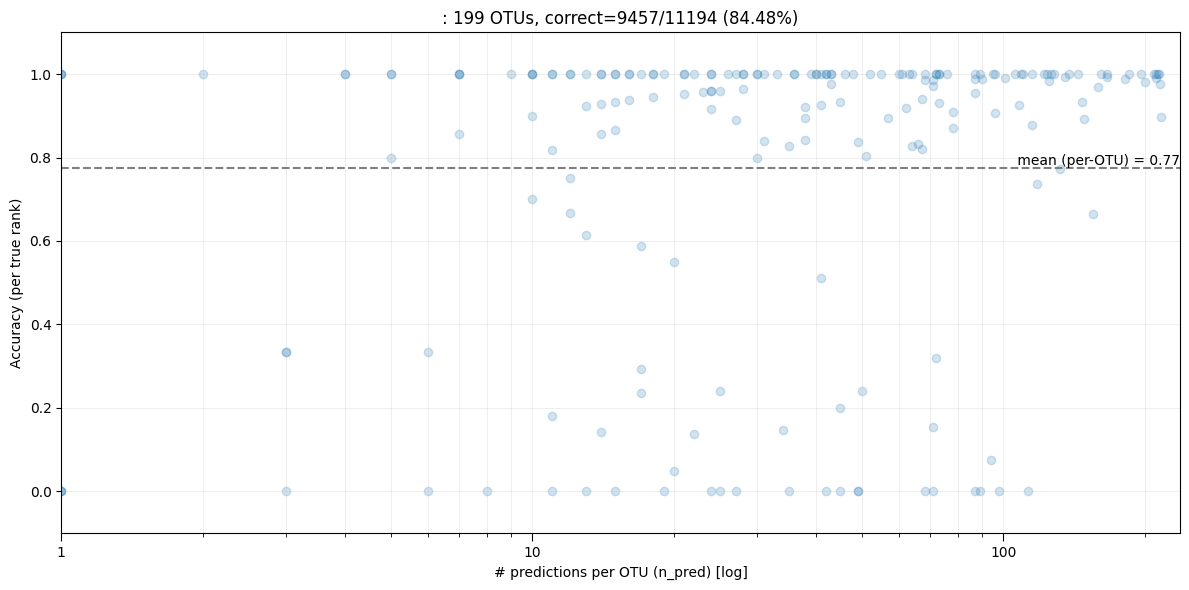

[INFO] multilabel eval: 9362 unique samples, 11194 predictions, 199 OTUs | correct=9457/11194 (84.48%)


In [30]:
df_raw, df_otu, summary, fig = evaluate_and_plot_predictions_multilabel(
    jsonl_path=OUT_JSONL,
    title_prefix=""#"Per-OTU rank accuracy vs # predictions (TEST subset)"
)


In [31]:
from otu_taxa.dataloaders_unk_balanced import build_tax2ancestor_at_rank, build_tax2rank_from_vocab 

RANKS = ("k","p","c","o","f","g","s")

# M_np must be the descendant closure used by the hierarchical loss: shape [T_base, T_base]
# tax_vocab_list must be length T_base (UNK-extended)
tax2rank = build_tax2rank_from_vocab(tax_vocab_unk)

ancestor_at_rank = {
    r: build_tax2ancestor_at_rank(
        M_np=M_np,                    # np.ndarray [T_base, T_base]
        tax_vocab_list=tax_vocab_unk,  # list[str] length T_base
        target_rank=r,
        missing_value=-1,
    )
    for r in RANKS
}

# quick sanity
for r in RANKS:
    assert len(ancestor_at_rank[r]) == M_np.shape[0]
print("[OK] built ancestor arrays for ranks:", RANKS)


# ------------------------------------------------------------
# 0) Build gold ancestor arrays 
# ------------------------------------------------------------
def build_ancestor_arrays_all_ranks(M_np, tax_vocab_unk, ranks=RANKS, missing_value=-1):
    """
    Returns dict rank -> dense list length T_base:
      ancestor_at_rank[r][t] = ancestor tax_id at rank r, else -1.
    """
    ancestor_at_rank = {}
    for r in ranks:
        ancestor_at_rank[r] = build_tax2ancestor_at_rank(
            M_np=M_np,
            tax_vocab_list=tax_vocab_unk,
            target_rank=r,
            missing_value=missing_value,
        )
    return ancestor_at_rank

[OK] built ancestor arrays for ranks: ('k', 'p', 'c', 'o', 'f', 'g', 's')


Global rankACC: 0.9160


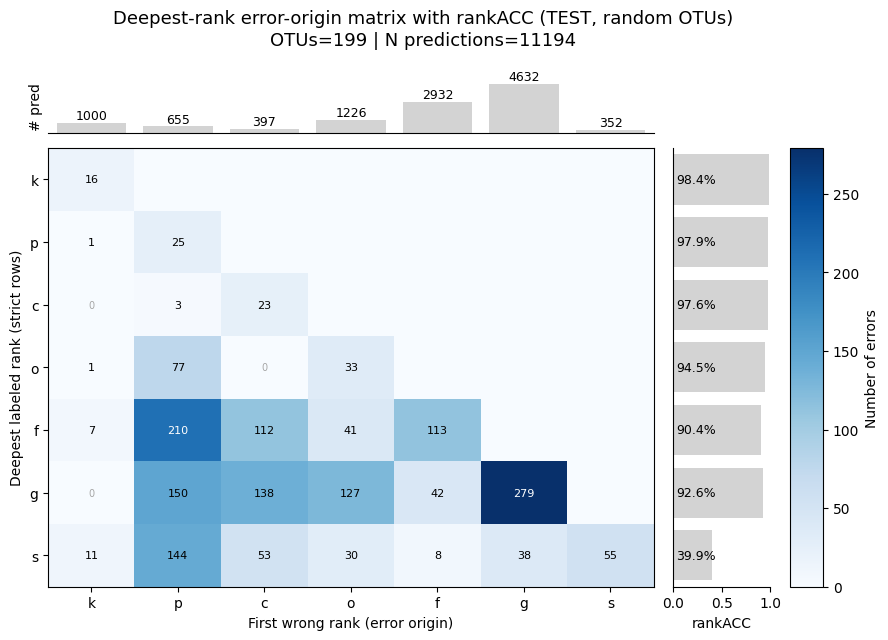

In [32]:
# 1) Build ancestor arrays from the same artifacts used by the new model
ancestor_at_rank = build_ancestor_arrays_all_ranks(
    M_np=M_np,                 # [T_base, T_base] np.ndarray
    tax_vocab_unk=tax_vocab_unk,
    ranks=RANKS,
    missing_value=-1,
)

# 2) Load predictions, add pred/gold columns
df = load_predictions_with_pred_gold(
    jsonl_path=OUT_JSONL,   # your JSONL path
    ancestor_at_rank=ancestor_at_rank,
    ranks=RANKS,
)

# 3) Strict matrix + meta for plot
counts_strict, meta_strict = strict_error_origin_matrix_and_rankACC(df, ranks=RANKS)

# 4) Plot
plot_strict_matrix_with_rankACC(
    counts_strict,
    meta_strict,
    title="Deepest-rank error-origin matrix with rankACC (TEST, random OTUs)",
    ranks=RANKS,
    df=df,
    otu_col="otu_id",   # or "otu_name" if your JSONL doesn’t have otu_id
    show_zeros_lower=True,
)

# 5) Global rankACC
global_rankACC, df_with_rankacc = compute_global_rankACC(df, ranks=RANKS)
print(f"Global rankACC: {global_rankACC:.4f}")


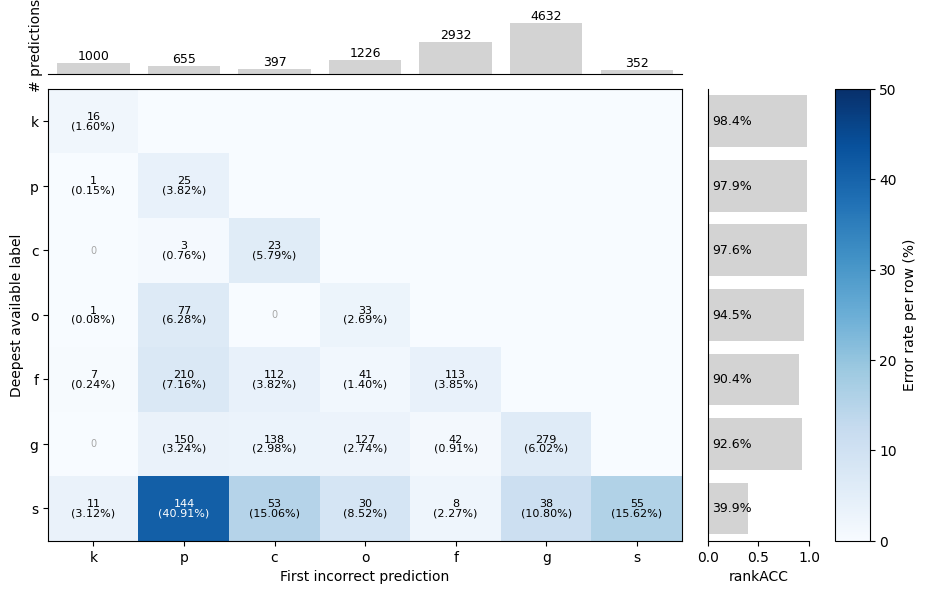

In [65]:
fig, axes = plot_error_origin_matrix_rowpct_colored(
    counts_strict,
    meta_strict,
    title= "",#"Deepest-rank error origin (TEST)",
    ranks=RANKS,
    df=df,
    otu_col="otu_id",
    show_zeros_lower=True,
    show_percent_text=True,  # keep the per-cell row %
    vmax_pct=50.0,            # fixed 0–5% scale for comparability
    vmin_pct=0.0,
)


In [43]:


acc_table = build_accuracy_vs_rankACC_table(df, ranks=RANKS)
display(
    acc_table
    .assign(
        standard_accuracy=lambda x: x["standard_accuracy"].map(lambda v: f"{v:.4f}" if pd.notna(v) else "—"),
        rankACC=lambda x: x["rankACC"].map(lambda v: f"{v:.4f}" if pd.notna(v) else "—"),
    )
)


,standard_accuracy,rankACC,n_rows
k,0.9915,0.9915,946
p,0.9937,0.9960,632
c,1.0000,1.0000,391
o,0.9941,0.9981,1195
f,0.9869,0.9947,2898
g,0.9826,0.9928,4718
s,0.2732,0.7097,377
Global,0.9630,0.9846,11157


# 5 runs of k shot experimetns diferent support sets

In [ ]:


# ----------------------------
# User config
# ----------------------------
K_LIST = [1, 5, 10, 20]
N_REPEATS = 5

K_MAX = max(K_LIST)            # 20
QUERY_MAX = 10_000
BATCH_SIZE_SUPPORT = 4
BATCH_SIZE_QUERY = 4

BASE_SEED = seed               # use your existing seed as base

# Top-level folder to keep everything together
ALL_PRED_ROOT = Path(RUN_DIR) / "kshot_simpler_repeats"
ALL_PRED_ROOT.mkdir(parents=True, exist_ok=True)

print("[INFO] Writing all predictions under:", ALL_PRED_ROOT)

# ----------------------------
# Collator (keep taxonomy-only masking)
# IMPORTANT: pass the same OTU set you want to mask in support+query
# If you prefer, you can use split_simple["usable_otus"] after split is built.
# ----------------------------
max_len = meta.get("max_len", 500)

def make_query_loader_for_repeat(query_indices, heldout_mask_ids):
    query_ds = Subset(test_ds, query_indices)
    query_loader = DataLoader(
        query_ds,
        batch_size=BATCH_SIZE_QUERY,
        shuffle=False,
        collate_fn=make_tax_only_mask_collator(
            ds,
            heldout_mask_ids,
            T_base=T_base,
            max_len=max_len,
        ),
    )
    return query_ds, query_loader

def make_support_loader_for_k(split_simple, k, heldout_mask_ids):
    support_idx_k = split_simple["get_support_indices_for_k"](k)
    support_ds_k = Subset(test_ds, support_idx_k)
    support_loader_k = DataLoader(
        support_ds_k,
        batch_size=BATCH_SIZE_SUPPORT,
        shuffle=True,
        collate_fn=make_tax_only_mask_collator(
            ds,
            heldout_mask_ids,
            T_base=T_base,
            max_len=max_len,
        ),
    )
    return support_ds_k, support_loader_k

# ----------------------------
# Run repeats
# ----------------------------
all_run_summaries = []

for rep in range(1, N_REPEATS + 1):
    rep_seed = BASE_SEED + rep  # different sampling each repeat, deterministic

    print("\n" + "="*80)
    print(f"[REPEAT {rep}/{N_REPEATS}] seed={rep_seed}")
    print("="*80)

    # 1) Build split (new support sampling) and fixed query for this repeat
    split_simple = build_kshot_support_query_split_simple(
        subset_ds=test_ds,
        heldout_otus=selected_otus_set,
        O_ds=O_ds,
        K_max=K_MAX,
        seed=rep_seed,
        allow_replacement=True,
        query_max=QUERY_MAX,
        query_frac=None,
        verbose=True,
    )

    # Prefer masking only usable OTUs (cleanest)
    heldout_mask_ids = split_simple["usable_otus"]

    # Shared query across k within this repeat
    query_ds, query_loader = make_query_loader_for_repeat(
        query_indices=split_simple["query_indices"],
        heldout_mask_ids=heldout_mask_ids,
    )
    print(f"[REPEAT {rep}] query samples (fixed across k) = {len(query_ds)}")
    print(f"[REPEAT {rep}] usable OTUs = {len(split_simple['usable_otus'])}")

    # Save split metadata for reproducibility
    rep_dir = ALL_PRED_ROOT / f"repeat_{rep:02d}_seed{rep_seed}"
    rep_dir.mkdir(parents=True, exist_ok=True)
    with open(rep_dir / "split_simple_meta.json", "w") as f:
        json.dump(
            {
                "repeat": rep,
                "seed": rep_seed,
                "K_max": split_simple["K_max"],
                "query_max": split_simple.get("query_max", None),
                "query_frac": split_simple.get("query_frac", None),
                "n_query": len(split_simple["query_indices"]),
                "n_usable_otus": len(split_simple["usable_otus"]),
                "usable_otus_preview": split_simple["usable_otus"][:25],
            },
            f,
            indent=2,
        )

    # 2) Run each k inside this repeat
    rep_summary = {"repeat": rep, "seed": rep_seed, "k_results": {}}

    for k in K_LIST:
        print("\n" + "-"*60)
        print(f"[REPEAT {rep}] k={k}")
        print("-"*60)

        # Build k-shot support loader (new subset derived from split_simple)
        support_ds_k, support_loader_k = make_support_loader_for_k(
            split_simple=split_simple,
            k=k,
            heldout_mask_ids=heldout_mask_ids,
        )
        print(f"[SUPPORT] k={k} | support samples (with repeats) = {len(support_ds_k)}")

        # Make a per-k folder inside this repeat folder
        PRED_DIR = rep_dir / f"predictions_{k}_shot_simpler"
        PRED_DIR.mkdir(parents=True, exist_ok=True)
        OUT_JSONL = PRED_DIR / "pred_taxonomy_per_rank.jsonl"

        # Always start from the same checkpoint
        reset_model_from_ckpt_inplace(model, CKPT_PATH, DEVICE)

        # Adapt (ONE EPOCH by design)
        stats_k = adapt_otu_embeddings_kshot(
            model=model,
            support_loader=support_loader_k,
            heldout_otu_ids=heldout_mask_ids,
            device=DEVICE,
            T_base=T_base,
            lr=1e-2,
        )

        # Evaluate on shared query and write JSONL
        print(f"[INFO] Saving predictions to: {OUT_JSONL}")
        eval_stats_k = evaluate_taxonomy_on_query_and_write_jsonl(
            model=model,
            query_loader=query_loader,
            out_jsonl_path=OUT_JSONL,
            device=DEVICE,
            T_base=T_base,
            pad_tax_id=pad_tax_id,
            mask_tax_id=mask_tax_id,
            M_dev=M_dev,
            rank_idx_dev=rank_idx_dev,
            tax_name_fn=_tax_name,
            otu_name_fn=_otu_name,
        )

        # Save per-k stats (adapt + eval) to JSON for quick summary later
        with open(PRED_DIR / "adapt_stats.json", "w") as f:
            json.dump(stats_k, f, indent=2)
        with open(PRED_DIR / "eval_stats.json", "w") as f:
            json.dump(eval_stats_k, f, indent=2)

        rep_summary["k_results"][str(k)] = {
            "support_size": int(len(support_ds_k)),
            "adapt": stats_k,
            "eval": eval_stats_k,
            "pred_jsonl": str(OUT_JSONL),
        }

    # Save repeat summary
    with open(rep_dir / "repeat_summary.json", "w") as f:
        json.dump(rep_summary, f, indent=2)

    all_run_summaries.append(rep_summary)

# Save global summary
with open(ALL_PRED_ROOT / "all_repeats_summary.json", "w") as f:
    json.dump(all_run_summaries, f, indent=2)

print("\n[OK] Finished all repeats.")
print("[INFO] Root folder:", ALL_PRED_ROOT)
print("[INFO] Wrote:", ALL_PRED_ROOT / "all_repeats_summary.json")


[INFO] Writing all predictions under: /home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_microbeatlas_k_shot/pretrain_tail_80_otus_200/kshot_simpler_repeats

[REPEAT 1/5] seed=124
[KSHOT SIMPLE] requested OTUs: 200 | usable OTUs: 200
[KSHOT SIMPLE] K_max=20 | allow_replacement=True | seed=124
[KSHOT SIMPLE] OTUs needing replacement: 1/200
[KSHOT SIMPLE] query_full size: 180403
[KSHOT SIMPLE] query_final size: 10000 (query_max=10000, query_frac=None)
[REPEAT 1] query samples (fixed across k) = 10000
[REPEAT 1] usable OTUs = 200

------------------------------------------------------------
[REPEAT 1] k=1
------------------------------------------------------------
[SUPPORT] k=1 | support samples (with repeats) = 200
[KSHOT-ADAPT] step=25 loss=13.665807
[KSHOT-ADAPT] step=50 loss=13.594707
[KSHOT-ADAPT DONE] epoch=1 steps=50 loss_mean=13.594707 trainable_rows=200 skipped_batches=0
[INFO] Saving predictions to: /home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_

In [47]:
def find_prediction_jsonl(pred_dir: Path) -> Path:
    jsonls = sorted(pred_dir.glob("*.jsonl"))
    if not jsonls:
        raise FileNotFoundError(f"No .jsonl found in {pred_dir}")
    # pick largest file (most likely the real predictions)
    jsonls = sorted(jsonls, key=lambda p: p.stat().st_size, reverse=True)
    return jsonls[0]

def compute_global_metrics_for_jsonl(jsonl_path: Path, ancestor_at_rank, ranks=RANKS):
    # 1) load and add pred_{r}, gold_{r}
    df = load_predictions_with_pred_gold(
        jsonl_path=jsonl_path,
        ancestor_at_rank=ancestor_at_rank,
        ranks=ranks,
    )

    # 2) build table (includes per-rank + Global)
    table = build_accuracy_vs_rankACC_table(df, ranks=ranks)

    # We only care about Global row:
    global_standard = float(table.loc["Global", "standard_accuracy"])
    global_rankacc  = float(table.loc["Global", "rankACC"])
    n_rows          = int(table.loc["Global", "n_rows"])
    return global_standard, global_rankacc, n_rows, table


In [63]:
ROOT = Path("/home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_microbeatlas_k_shot/pretrain_tail_80_otus_200")  # <-- set this
REPEATS_DIR = ROOT / "kshot_simpler_repeats"

def parse_k_from_folder(name: str) -> int:
    # e.g. predictions_10_shot_simpler -> 10
    m = re.search(r"predictions_(\d+)_shot", name)
    if not m:
        raise ValueError(f"Cannot parse k-shot from folder name: {name}")
    return int(m.group(1))

rows = []
repeat_dirs = sorted([p for p in REPEATS_DIR.glob("repeat_*") if p.is_dir()])

for rep_dir in repeat_dirs:
    pred_dirs = sorted([p for p in rep_dir.glob("predictions_*") if p.is_dir()])
    if not pred_dirs:
        print(f"[WARN] No predictions_* folders in {rep_dir}")
        continue

    for pd_ in pred_dirs:
        k = parse_k_from_folder(pd_.name)
        jsonl_path = find_prediction_jsonl(pd_)

        std_acc, rankacc, n_rows, _ = compute_global_metrics_for_jsonl(
            jsonl_path=jsonl_path,
            ancestor_at_rank=ancestor_at_rank,
            ranks=RANKS,
        )

        rows.append({
            "repeat": rep_dir.name,
            "k_shot": k,
            "jsonl": str(jsonl_path),
            "standard_accuracy": std_acc,
            "rankACC": rankacc,
            "n_rows": n_rows,
        })

df_runs = pd.DataFrame(rows).sort_values(["k_shot", "repeat"]).reset_index(drop=True)
df_runs


,repeat,k_shot,jsonl,standard_accuracy,rankACC,n_rows
0,repeat_01_seed124,0,/home/hernan_melmoth/Documents/phd_work/otu-ta...,0.129336,0.400724,11157
1,repeat_02_seed125,0,/home/hernan_melmoth/Documents/phd_work/otu-ta...,0.137248,0.406367,11257
2,repeat_03_seed126,0,/home/hernan_melmoth/Documents/phd_work/otu-ta...,0.133063,0.404038,11115
3,repeat_04_seed127,0,/home/hernan_melmoth/Documents/phd_work/otu-ta...,0.134478,0.404738,11065
4,repeat_05_seed128,0,/home/hernan_melmoth/Documents/phd_work/otu-ta...,0.133950,0.404270,11243
5,repeat_01_seed124,1,/home/hernan_melmoth/Documents/phd_work/otu-ta...,0.136058,0.388456,11157
6,repeat_02_seed125,1,/home/hernan_melmoth/Documents/phd_work/otu-ta...,0.169672,0.418372,11257
7,repeat_03_seed126,1,/home/hernan_melmoth/Documents/phd_work/otu-ta...,0.151507,0.408929,11115
8,repeat_04_seed127,1,/home/hernan_melmoth/Documents/phd_work/otu-ta...,0.169544,0.416479,11065
9,repeat_05_seed128,1,/home/hernan_melmoth/Documents/phd_work/otu-ta...,0.158943,0.407453,11243


In [64]:
summary = (
    df_runs
    .groupby("k_shot")
    .agg(
        n_repeats=("repeat", "nunique"),
        standard_accuracy_mean=("standard_accuracy", "mean"),
        standard_accuracy_std=("standard_accuracy", "std"),
        rankACC_mean=("rankACC", "mean"),
        rankACC_std=("rankACC", "std"),
        n_rows_mean=("n_rows", "mean"),
    )
    .reset_index()
    .sort_values("k_shot")
)

summary


,k_shot,n_repeats,standard_accuracy_mean,standard_accuracy_std,rankACC_mean,rankACC_std,n_rows_mean
0,0,5,0.133615,0.002858,0.404027,0.002058,11167.4
1,1,5,0.157145,0.014056,0.407938,0.011859,11167.4
2,5,5,0.807786,0.017083,0.899536,0.008717,11167.4
3,10,5,0.956821,0.004526,0.983752,0.001114,11167.4
4,20,5,0.991250,0.002454,0.996966,0.000962,11167.4


# zero shot

In [61]:
from typing import Any, Dict, List, Optional, Iterable
import torch

IGNORE_INDEX = -100  # use the same value you use elsewhere

def make_zero_shot_otu_mask_tax_mask_collator(
    dataset,
    heldout_otu_ids: Iterable[int],
    *,
    T_base: int,
    max_len: Optional[int] = None,
):
    heldout_otu_ids = set(map(int, heldout_otu_ids))

    O, T = dataset.O, dataset.T
    pad_otu_id, mask_otu_id = O, O + 1
    pad_tax_id, mask_tax_id = T_base, T_base + 1

    def collate(batch: List[Dict[str, Any]]) -> Dict[str, Any]:
        lengths = [b["length"] for b in batch]
        L = max_len if max_len is not None else max(lengths)
        B = len(batch)

        input_otus = torch.full((B, L), pad_otu_id, dtype=torch.long)
        input_taxa = torch.full((B, L), pad_tax_id, dtype=torch.long)
        labels_otu = torch.full((B, L), IGNORE_INDEX, dtype=torch.long)
        labels_taxa = torch.full((B, L), IGNORE_INDEX, dtype=torch.long)
        attention_mask = torch.zeros((B, L), dtype=torch.long)

        sample_ids: List[str] = []

        for b, rec in enumerate(batch):
            sample_ids.append(rec["sample_id"])
            otus_raw = rec["otus"]
            taxa_raw = rec["taxa"]

            otus_p = otus_raw[:L] + [pad_otu_id] * max(0, L - len(otus_raw))
            taxa_p = taxa_raw[:L] + [pad_tax_id] * max(0, L - len(taxa_raw))

            input_otus[b] = torch.tensor(otus_p, dtype=torch.long)
            input_taxa[b] = torch.tensor(taxa_p, dtype=torch.long)
            attention_mask[b] = (input_otus[b] != pad_otu_id).long()

        true_otus = input_otus.clone()
        true_taxa = input_taxa.clone()

        for b in range(B):
            for i in range(L):
                if attention_mask[b, i].item() == 0:
                    continue

                otu = int(true_otus[b, i].item())
                if otu in heldout_otu_ids:
                    input_otus[b, i] = mask_otu_id

                    t = int(true_taxa[b, i].item())
                    if t != pad_tax_id:
                        input_taxa[b, i] = mask_tax_id
                        labels_taxa[b, i] = t

        # evaluator expects masked_positions[bi] = list of indices to score
        masked_positions: List[List[int]] = []
        for b in range(B):
            pos = torch.nonzero(labels_taxa[b] != IGNORE_INDEX, as_tuple=False).view(-1).tolist()
            masked_positions.append(pos)

        return {
            "sample_ids": sample_ids,
            "masked_positions": masked_positions,

            "input_otus": input_otus,
            "input_taxa": input_taxa,
            "labels_otu": labels_otu,
            "labels_taxa": labels_taxa,
            "attention_mask": attention_mask,
            "lengths": torch.tensor(lengths),

            # 
            "true_otus": true_otus,
            "true_taxa": true_taxa,

            "special_ids": {
                "otu": {"pad": pad_otu_id, "mask": mask_otu_id},
                "tax": {"pad": pad_tax_id, "mask": mask_tax_id},
                "vocab_sizes": {"otu": O + 2, "tax": T_base + 2},
            },
        }

    return collate


In [62]:
# ============================================================
# ZERO-SHOT EVAL LOOP (OTU masked with learned [MASK] token)
# - Same repeats/splits as k-shot
# - No adaptation
# - Saves under: kshot_simpler_repeats/repeat_XX_seedYYY/predictions_0_shot_simpler/
# ============================================================


# ----------------------------
# User config (0-shot)
# ----------------------------
N_REPEATS = 5
QUERY_MAX = 10_000
BATCH_SIZE_QUERY = 4

BASE_SEED = seed  # use your existing seed as base

# Top-level folder to keep everything together (same root you used)
ALL_PRED_ROOT = Path(RUN_DIR) / "kshot_simpler_repeats"
ALL_PRED_ROOT.mkdir(parents=True, exist_ok=True)

print("[INFO] Writing all zero-shot predictions under:", ALL_PRED_ROOT)

# ----------------------------
# Max length (same as before)
# ----------------------------
max_len = meta.get("max_len", 500)

# ----------------------------
# Run repeats (0-shot)
# ----------------------------
all_run_summaries_0shot = []

for rep in range(1, N_REPEATS + 1):
    rep_seed = BASE_SEED + rep  # deterministic but different each repeat

    print("\n" + "=" * 80)
    print(f"[REPEAT {rep}/{N_REPEATS}] ZERO-SHOT seed={rep_seed}")
    print("=" * 80)

    # 1) Build split (same function as k-shot so query sampling is comparable)
    split_simple = build_kshot_support_query_split_simple(
        subset_ds=test_ds,
        heldout_otus=selected_otus_set,
        O_ds=O_ds,
        K_max=20,                  # keep same as before so usable_otus logic matches
        seed=rep_seed,
        allow_replacement=True,
        query_max=QUERY_MAX,
        query_frac=None,
        verbose=True,
    )

    # Mask only "usable_otus" (cleanest)
    heldout_mask_ids = split_simple["usable_otus"]

    # Fixed query set for this repeat
    query_indices = split_simple["query_indices"]
    query_ds = Subset(test_ds, query_indices)

    # 2) Build ZERO-SHOT query loader:
    #    - mask OTU token with learned mask_otu_id
    #    - mask TAX token and supervise labels_taxa at those positions
    query_loader = DataLoader(
        query_ds,
        batch_size=BATCH_SIZE_QUERY,
        shuffle=False,
        collate_fn=make_zero_shot_otu_mask_tax_mask_collator(
            dataset=ds,
            heldout_otu_ids=heldout_mask_ids,
            T_base=T_base,
            max_len=max_len,
        ),
    )

    print(f"[REPEAT {rep}] query samples = {len(query_ds)}")
    print(f"[REPEAT {rep}] usable OTUs  = {len(heldout_mask_ids)}")

    # 3) Prepare repeat folder
    rep_dir = ALL_PRED_ROOT / f"repeat_{rep:02d}_seed{rep_seed}"
    rep_dir.mkdir(parents=True, exist_ok=True)

    # Save split metadata (same style as your k-shot loop)
    with open(rep_dir / "split_simple_meta.json", "w") as f:
        json.dump(
            {
                "repeat": rep,
                "seed": rep_seed,
                "K_max": split_simple["K_max"],
                "query_max": split_simple.get("query_max", None),
                "query_frac": split_simple.get("query_frac", None),
                "n_query": len(split_simple["query_indices"]),
                "n_usable_otus": len(split_simple["usable_otus"]),
                "usable_otus_preview": split_simple["usable_otus"][:25],
            },
            f,
            indent=2,
        )

    # 4) Zero-shot output folder (inside repeat folder)
    PRED_DIR = rep_dir / "predictions_0_shot_simpler"
    PRED_DIR.mkdir(parents=True, exist_ok=True)
    OUT_JSONL = PRED_DIR / "pred_taxonomy_per_rank.jsonl"

    # 5) Reset model from checkpoint (no adaptation in 0-shot)
    reset_model_from_ckpt_inplace(model, CKPT_PATH, DEVICE)

    # 6) Evaluate on query and write JSONL
    print(f"[INFO] Saving ZERO-SHOT predictions to: {OUT_JSONL}")
    eval_stats_0 = evaluate_taxonomy_on_query_and_write_jsonl(
        model=model,
        query_loader=query_loader,
        out_jsonl_path=OUT_JSONL,
        device=DEVICE,
        T_base=T_base,
        pad_tax_id=pad_tax_id,
        mask_tax_id=mask_tax_id,
        M_dev=M_dev,
        rank_idx_dev=rank_idx_dev,
        tax_name_fn=_tax_name,
        otu_name_fn=_otu_name,
    )

    # Save eval stats
    with open(PRED_DIR / "eval_stats.json", "w") as f:
        json.dump(eval_stats_0, f, indent=2)

    # Save repeat summary (0-shot specific)
    rep_summary_0 = {
        "repeat": rep,
        "seed": rep_seed,
        "mode": "zero_shot_otu_mask_tax_mask",
        "n_query": int(len(query_ds)),
        "n_usable_otus": int(len(heldout_mask_ids)),
        "pred_jsonl": str(OUT_JSONL),
        "eval": eval_stats_0,
    }
    with open(rep_dir / "repeat_summary_0shot.json", "w") as f:
        json.dump(rep_summary_0, f, indent=2)

    all_run_summaries_0shot.append(rep_summary_0)

# 7) Save global summary across repeats
with open(ALL_PRED_ROOT / "all_repeats_summary_0shot.json", "w") as f:
    json.dump(all_run_summaries_0shot, f, indent=2)

print("\n[OK] Finished ZERO-SHOT repeats.")
print("[INFO] Root folder:", ALL_PRED_ROOT)
print("[INFO] Wrote:", ALL_PRED_ROOT / "all_repeats_summary_0shot.json")


[INFO] Writing all zero-shot predictions under: /home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_microbeatlas_k_shot/pretrain_tail_80_otus_200/kshot_simpler_repeats

[REPEAT 1/5] ZERO-SHOT seed=124
[KSHOT SIMPLE] requested OTUs: 200 | usable OTUs: 200
[KSHOT SIMPLE] K_max=20 | allow_replacement=True | seed=124
[KSHOT SIMPLE] OTUs needing replacement: 1/200
[KSHOT SIMPLE] query_full size: 180403
[KSHOT SIMPLE] query_final size: 10000 (query_max=10000, query_frac=None)
[REPEAT 1] query samples = 10000
[REPEAT 1] usable OTUs  = 200
[INFO] Saving ZERO-SHOT predictions to: /home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_microbeatlas_k_shot/pretrain_tail_80_otus_200/kshot_simpler_repeats/repeat_01_seed124/predictions_0_shot_simpler/pred_taxonomy_per_rank.jsonl
[DONE] wrote predictions to: /home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_microbeatlas_k_shot/pretrain_tail_80_otus_200/kshot_simpler_repeats/repeat_01_seed124/predictions_0_shot_sim